__Install necesary libraries for dutch sentiment analysis__

In [83]:
!pip install -U textblob
!pip install textblob-nl
!python -m textblob.download_corpora

Finished.


[nltk_data] Downloading package brown to
[nltk_data]     C:\Users\sasja\AppData\Roaming\nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\sasja\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\sasja\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\sasja\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package conll2000 to
[nltk_data]     C:\Users\sasja\AppData\Roaming\nltk_data...
[nltk_data]   Package conll2000 is already up-to-date!
[nltk_data] Downloading package movie_reviews to
[nltk_data]     C:\Users\sasja\AppData\Roaming\nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!

## Filtering the twitter dataset on user
Filter out the users that where excluded in the network analysis in order to compare the different clusters

In [1]:
import pandas as pd

network_data = pd.read_csv ('data/network_stats/complete.csv')
tweets = pd.read_csv ('data/cleaned_w_rt/cleaned_rt.csv')

network_data = network_data.rename(columns={"Id": "username"})

print("Number of tweets:", len(tweets))
print("Number of twitter users in twitter data:", network_data.username.nunique())
print("Number of twitter users in network data:", tweets.username.nunique())

Number of tweets: 11690
Number of twitter users in twitter data: 3054
Number of twitter users in network data: 5432


In [2]:
data = tweets[tweets["username"].isin(network_data['username'])]
data = data.merge(network_data.loc[:,['username','modularity_class']], on="username", how='inner')

print("Number of tweets:", len(data))
print("Number of twitter users:", data.username.nunique())
print("Modularity groups:",data["modularity_class"].unique())

Number of tweets: 8248
Number of twitter users: 2662
Modularity groups: [2 4 3 1 0]


## Apply sentiment analysis on data
Using the dutch version of TextBlob, calculate the polarity and subjectivity score

In [3]:
from tqdm.notebook import tqdm
tqdm.pandas()

from textblob import TextBlob
from textblob_nl import PatternTagger, PatternAnalyzer

sentiment = data.clean_text.progress_apply(lambda x: tuple(TextBlob(text=x, analyzer=PatternAnalyzer()).sentiment))

data["polarity"] = sentiment.str.get(0)
data["subjectivity"] = sentiment.str.get(1)

  0%|          | 0/8248 [00:00<?, ?it/s]

## Visualize polarity
Use matplotlib and seaborn to visualize the polarity score of the data set

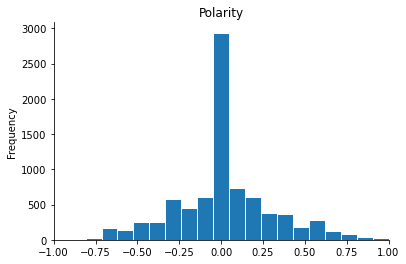

In [4]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns

fig, ax = plt.subplots(figsize=(6, 4))

data["polarity"].plot(kind="hist", bins=21, edgecolor="white",  title="Polarity")
ax.set_xlim(-1, 1)
sns.despine()

plt.savefig("figures/histogram_polarity_subjectivity.png")

In [5]:
data["polarity_text"] = 0

data.loc[data.polarity > 0, 'polarity_text'] = 'Positive'
data.loc[data.polarity < 0, 'polarity_text'] = 'Negative'
data.loc[data.polarity == 0, 'polarity_text'] = 'Neutral'

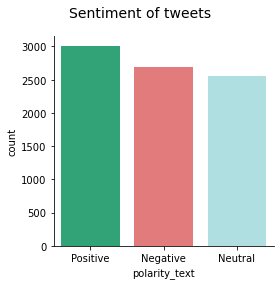

In [6]:
fc = sns.catplot(x="polarity_text",
                    data=data, kind="count", 
                    palette={"Negative": "#F36B6B", 
                             "Positive": "#1FB57B", 
                             "Neutral": "#A8E7E9"},
                    height=4, aspect=1)
fc.fig.suptitle('Sentiment of tweets', fontsize=14)
plt.tight_layout()
plt.savefig("figures/catplot_sentiment.png")

In [7]:
data['polarity_text'].value_counts(normalize=True) * 100

Positive    36.420951
Negative    32.613967
Neutral     30.965082
Name: polarity_text, dtype: float64

In [12]:
pos = data[data.polarity == 1]
print("Most positive tweet:")
print(data.iloc[pos.index[6]]["text"])

Most positive tweet:
Iedereen een heel mooi Sinterklaas weekend toegewenst!!!

#sinterklaas 
#ZwartePiet https://t.co/mJre5bLb3E


In [13]:
neg = data[data.polarity == -1]
print("Most negative tweet:")
print(data.iloc[neg.index[4]]["text"])

Most negative tweet:
@Samslifeinpiec2 @Marcel_Meijvis @LWinnips @volkskrant Ja, mee eens, KOZP zijn beestachtige racisten.


In [14]:
neu = data[data.polarity == 0]
print("Neutral tweet example:")
print(data.iloc[neu.index[5]]["text"])
print(data.iloc[neu.index[5]]["tweet_id"])

Neutral tweet example:
RT @050Roy: @ashatenbroeke @ChrisAalberts Er was geen demonstratierecht in Volendam vandaag, de demonstratie was niet aangemeld door KOZP e…
1467246890806878214


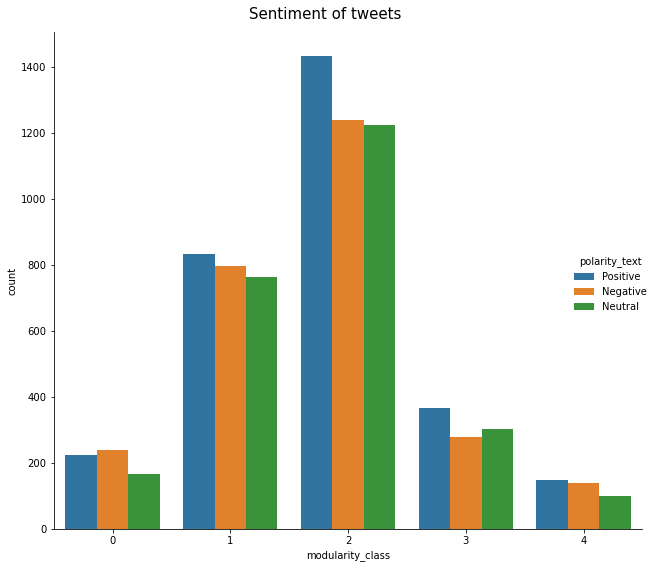

In [23]:
fc = sns.catplot(x="modularity_class",
                    data=data, hue="polarity_text", kind="count",
                    height=8)
fc.fig.suptitle('Sentiment of tweets', fontsize=15)
plt.tight_layout()
plt.savefig("figures/catplot_sentiment_per_group.png")

## Visualize subjectivity
Use matplotlib and seaborn to visualize the subjectivity score of the data set

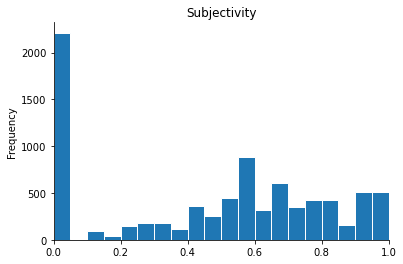

In [15]:
fig, ax = plt.subplots(figsize=(6, 4))

data["subjectivity"].plot(kind="hist", bins=20, edgecolor="white", title="Subjectivity")
ax.set_xlim(0, 1)
sns.despine()

plt.savefig("figures/histogram_subjectivity.png")

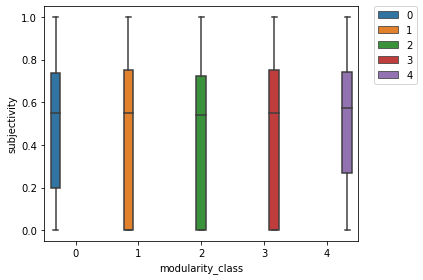

In [43]:
bp = sns.boxplot(x='modularity_class', y="subjectivity", 
                 hue='modularity_class', data=data)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.tight_layout()
plt.savefig("figures/boxplot_subjectivity.png")

In [19]:
obj = data[data.subjectivity == 0]
print("Most objective tweet:")
print(data.iloc[obj.index[6]]["text"])

Most objective tweet:
RT @Natassanews: @RutgerGW Uit de berichtgeving begreep ik dat KOZP zelf begon met het gooien van eieren naar Volendammers.


In [21]:
subj = data[data.subjectivity == 1]
print("Most subjective tweet:")
print(data.iloc[subj.index[1]]["text"])
print("tweet ID:", data.iloc[subj.index[1]]["tweet_id"])

Most subjective tweet:
RT @Harm_Zwiers: @jesseklaver Als je wil actie voeren prima maar niet over ruggen van een kinderfeest.
Van mijn part vraag je op onafhankel…
tweet ID: 1467511094377865219


## Statistical significance
Determine the statistical significance with the Kruskal-Wallis H-test

In [22]:
from scipy import stats

#divide data into modularity classes
group0 = data.loc[data["modularity_class"] == 0]
group1 = data.loc[data["modularity_class"] == 1]
group2 = data.loc[data["modularity_class"] == 2]
group3 = data.loc[data["modularity_class"] == 3]
group4 = data.loc[data["modularity_class"] == 4]

#perform Kruskal-Wallis H-test on polarity
stats.kruskal(group0["polarity"], group1["polarity"], group2["polarity"], group3["polarity"], group4["polarity"])

KruskalResult(statistic=9.049580333838179, pvalue=0.05987208560599259)

In [23]:
#perform Kruskal-Wallis H-test on subjectivity
stats.kruskal(group0["subjectivity"], group1["subjectivity"], group2["subjectivity"], 
              group3["subjectivity"], group4["subjectivity"])

KruskalResult(statistic=10.759982446483821, pvalue=0.029398121490683684)

In [31]:
#find the statistical significance between groups
print("Group 1 vs 2:",stats.kruskal(group1["subjectivity"], group2["subjectivity"]).pvalue)
print("Group 1 vs 3:",stats.kruskal(group1["subjectivity"], group3["subjectivity"]).pvalue)
print("Group 1 vs 4:",stats.kruskal(group1["subjectivity"], group4["subjectivity"]).pvalue)
print("Group 2 vs 3:",stats.kruskal(group2["subjectivity"], group3["subjectivity"]).pvalue)
print("Group 2 vs 4:",stats.kruskal(group2["subjectivity"], group4["subjectivity"]).pvalue)
print("Group 3 vs 4:",stats.kruskal(group3["subjectivity"], group4["subjectivity"]).pvalue)

Group 1 vs 2: 0.17301156654009808
Group 1 vs 3: 0.5905843971209647
Group 1 vs 4: 0.05808591065703074
Group 2 vs 3: 0.12013555007199728
Group 2 vs 4: 0.00668960754342059
Group 3 vs 4: 0.1691804667440451
